In this notebook we will explore the difference between the routine implementation of Multi-Head Attention, and the Flash Attention 2 implementation!

## Installing Dependencies

Colab comes equipped with most of what we need - but we'll need to downgrade `torch` to make sure we can install Flash Attention in a reasonable timeframe.

In [ ]:
!pip install -qU torch=='2.4.1+cu121' torchvision=='0.19.1+cu121' torchaudio=='2.4.1+cu121' --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

> NOTE: This cell still might take over a minute to run.

In [ ]:
!pip install -qU flash_attn accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 61.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Import Wall

Let's get our imports out of the way!

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import time
import pandas as pd
import gc
from tqdm.notebook import tqdm
from tabulate import tabulate
import numpy as np

## Helper Functions for Benchmarking

We'll construct a number of helper functions to run our simple benchmark in Colab.

### Load Model

This will load our model with the desired attention implementation.

> NOTE: We're using [`Phi-3.5-mini-instruct`](https://huggingface.co/microsoft/Phi-3.5-mini-instruct) today, which is a very small model that we should be able to run in the `A100` instance without running into memory issues, including longer contexts.

In [ ]:
def load_model(attn_impl=None):
    kwargs = {
        "device_map": "cuda",
        "torch_dtype": "auto",
        "trust_remote_code": True
    }
    if attn_impl:
        kwargs["attn_implementation"] = attn_impl

    return AutoModelForCausalLM.from_pretrained("microsoft/Phi-3.5-mini-instruct", **kwargs)

### Clear Memory

In order to ensure we don't overwhelm our memory, we'll clear our memory between runs.

In [ ]:
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

### Run Inference

This will handle running our inference.

In [ ]:
def run_inference(model, input_ids, attention_mask):
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attention_mask)

### Benchmark Sequence

Our benchmark sequence will follow these steps:

1. Tokenize our inputs
2. Create an attention mask. (not strictly necessary since we aren't padding sequences, just explicitly defined)
3. Warmup to get consistent trials
4. Run our trials and collect the mean/std for trial times.

In [ ]:
def benchmark_sequence(model, tokenizer, text, n_trials=10):
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to("cuda")
    attention_mask = torch.ones_like(input_ids)

    for _ in range(3):
        run_inference(model, input_ids, attention_mask)

    times = []
    for _ in range(n_trials):
        torch.cuda.synchronize()
        start = time.perf_counter()
        run_inference(model, input_ids, attention_mask)
        torch.cuda.synchronize()
        times.append(time.perf_counter() - start)

    return np.mean(times), np.std(times)

### Pre-Download the Model

While this isn't necessary, it prevents our first trial being (non-impactfully) from being extended.

In [ ]:
_ = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map=None,  # Download only
    torch_dtype="auto",
    trust_remote_code=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Pre-Download the Tokenizer

Same as above!

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

## Running the Benchmarks

Finally, we can actually set-up our experiments and run our benchmarks!

### Creating the Experiment List

We're going to test Flash Attention 2 against naive Attention at a number of sequence lengths to determine if/when there is a crossover.

We'll run from 512 to 6656 in increments of 512 - this will help us see the performance at very lower to medium sequence lengths.

> NOTE: We could extend this outside of a Colab environment - but we'll keep the sequence lengths shorter to fit it in the A100 instance.

In [ ]:
sequence_lengths = list(range(512, 6656, 512))
implementations = [None, "flash_attention_2"]
results = {length: {'mean': {}, 'std': {}} for length in sequence_lengths}

### Creating Sequences

Since we want to test from a variety of sequences, we can use our tokenizer to create sequences (the contents of the sequences don't matter very much).

The helper function will create "exact length" sequences.

In [ ]:
def create_exact_length_sequence(tokenizer, target_length):
    base_text = "This is a test sequence. "
    current_tokens = []

    while len(current_tokens) < target_length:
        new_tokens = tokenizer.encode(base_text)
        space_left = target_length - len(current_tokens)
        current_tokens.extend(new_tokens[:space_left])

    return tokenizer.decode(current_tokens)

Here we can create our sequences from 512 to are max sequence length!

In [ ]:
sequences = {
    length: create_exact_length_sequence(tokenizer, length)
    for length in sequence_lengths
}

## Running the Benchmark

Finally, we can run our benchmark!

In [ ]:
results_table = []
for impl in implementations:
    impl_name = 'naive' if impl is None else impl
    print(f"\n{'-'*20}\nTesting {impl_name}\n{'-'*20}")
    model = load_model(impl)

    for length in tqdm(sequence_lengths, desc=f"{impl_name} sequences"):
        mean_time, std_time = benchmark_sequence(model, tokenizer, sequences[length])
        results[length]['mean'][impl] = mean_time
        results[length]['std'][impl] = std_time
        results_table.append([impl_name, length, f"{mean_time:.4f} ± {std_time:.4f}"])

    del model
    clear_memory()


--------------------
Testing naive
--------------------


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

naive sequences:   0%|          | 0/12 [00:00<?, ?it/s]


--------------------
Testing flash_attention_2
--------------------


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

flash_attention_2 sequences:   0%|          | 0/12 [00:00<?, ?it/s]

## Viewing Results

First, let's convert to a Pandas DataFrame.

In [ ]:
df_results = pd.DataFrame(results).T
df_results.columns = ['Naive', 'Flash Attention 2']

Now we can plot our findings!

This appears to fairly conclusively indicates that (especially as sequence length increases) Flash Attention is considerably faster than the naive implementation.

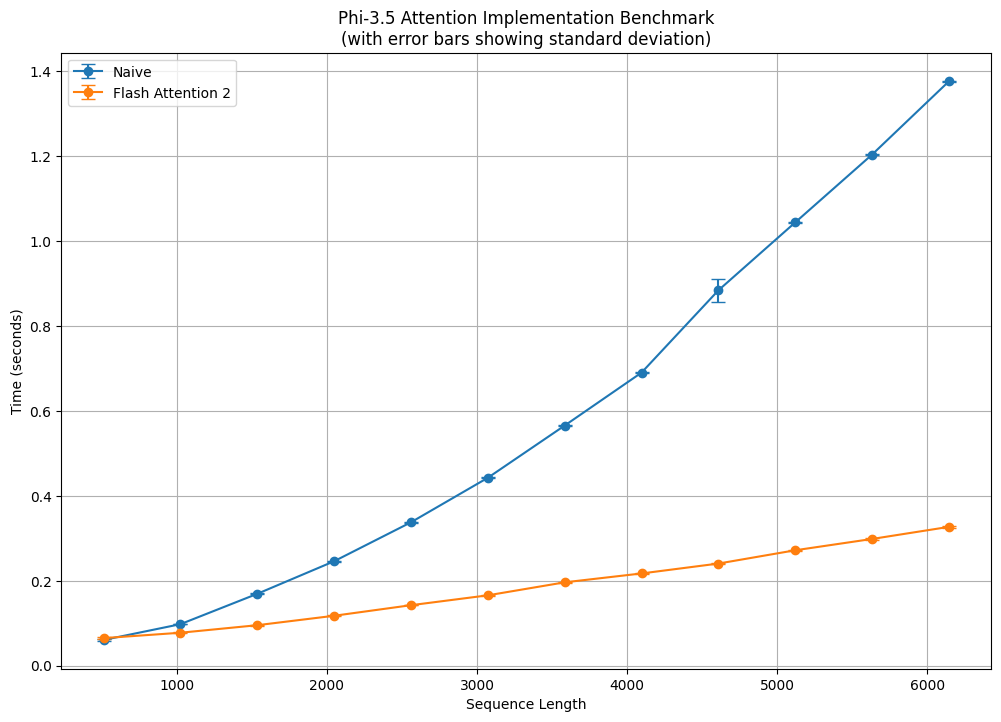

In [ ]:
plt.figure(figsize=(12, 8))
for impl in implementations:
    label = 'Naive' if impl is None else 'Flash Attention 2'
    means = [results[length]['mean'][impl] for length in sequence_lengths]
    stds = [results[length]['std'][impl] for length in sequence_lengths]

    plt.errorbar(sequence_lengths, means, yerr=stds,
                marker='o', label=label, capsize=5)

plt.xlabel('Sequence Length')
plt.ylabel('Time (seconds)')
plt.title('Phi-3.5 Attention Implementation Benchmark\n(with error bars showing standard deviation)')
plt.legend()
plt.grid(True)
plt.show()

A closer look at the data.

In [ ]:
df_means = pd.DataFrame({length: {impl_name: results[length]['mean'][impl]
                                for impl, impl_name in zip(implementations, ['Naive', 'Flash Attention 2'])}
                        for length in sequence_lengths}).T
df_stds = pd.DataFrame({length: {impl_name: results[length]['std'][impl]
                               for impl, impl_name in zip(implementations, ['Naive', 'Flash Attention 2'])}
                       for length in sequence_lengths}).T

print("\nMean times (seconds):")
print(df_means.round(4))
print("\nStandard deviations (seconds):")
print(df_stds.round(4))


Mean times (seconds):
       Naive  Flash Attention 2
512   0.0602             0.0646
1024  0.0974             0.0773
1536  0.1689             0.0950
2048  0.2456             0.1172
2560  0.3374             0.1421
3072  0.4422             0.1654
3584  0.5653             0.1960
4096  0.6900             0.2169
4608  0.8838             0.2402
5120  1.0438             0.2715
5632  1.2035             0.2982
6144  1.3761             0.3266

Standard deviations (seconds):
       Naive  Flash Attention 2
512   0.0017             0.0028
1024  0.0007             0.0017
1536  0.0008             0.0008
2048  0.0009             0.0007
2560  0.0008             0.0007
3072  0.0013             0.0008
3584  0.0006             0.0011
4096  0.0009             0.0010
4608  0.0268             0.0007
5120  0.0008             0.0010
5632  0.0014             0.0019
6144  0.0012             0.0017
